In [3]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

## Fixed Random Seed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

## Data Load

In [5]:
base_path = "/home/jinjinjara1022/"

weather_forecast_data_1 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_1.csv")
weather_forecast_data_2 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_2.csv")  

weather_observed_data_1 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_1.csv")
weather_observed_data_2 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_2.csv")  
  
jeju_power_market_day_ahead = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_하루전가격.csv")
jeju_power_market_real_time = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_실시간가격.csv")

jeju_power_market_status = pd.read_csv(base_path + "OBIC/data/제주전력시장_현황데이터.csv")

## Data preprocessing

In [6]:
df = jeju_power_market_day_ahead

In [7]:
df['datetimes'] = pd.to_datetime(df['ts'], unit='s')

df['month'] = df['datetimes'].dt.month
df['hour'] = df['datetimes'].dt.hour

In [8]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['mobth_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [9]:
df = df.drop(['ts', 'datetimes', 'month', 'hour'], axis=1)
df = df[[col for col in df.columns if col != '하루전가격(원/kWh)'] + ['하루전가격(원/kWh)']]

In [10]:
df['previous_ahead_price'] = df['하루전가격(원/kWh)'].shift(24)
df = df[[col for col in df.columns if col != '하루전가격(원/kWh)'] + ['하루전가격(원/kWh)']]

In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the 'previous_ahead_price' column
df['normalized_previous_ahead_price'] = scaler.fit_transform(df[['previous_ahead_price']])
df = df.drop(['previous_ahead_price'], axis=1)

df = df[[col for col in df.columns if col != '하루전가격(원/kWh)'] + ['하루전가격(원/kWh)']]

In [12]:
train_df = df[24:int(len(df) * 0.8)]
vali_df = df[int(len(df) * 0.8):]

In [13]:
train_df

,hour_sin,hour_cos,month_sin,mobth_cos,normalized_previous_ahead_price,하루전가격(원/kWh)
24,-0.707107,-7.071068e-01,1.0,6.123234e-17,0.456269,112.19
25,-0.866025,-5.000000e-01,1.0,6.123234e-17,0.456269,138.50
26,-0.965926,-2.588190e-01,1.0,6.123234e-17,0.426725,99.48
27,-1.000000,-1.836970e-16,1.0,6.123234e-17,0.408617,95.38
28,-0.965926,2.588190e-01,1.0,6.123234e-17,0.193837,91.24
...,...,...,...,...,...,...
4527,1.000000,6.123234e-17,-1.0,-1.836970e-16,0.563036,150.69
4528,0.965926,-2.588190e-01,-1.0,-1.836970e-16,0.562816,152.93
4529,0.866025,-5.000000e-01,-1.0,-1.836970e-16,0.587498,152.93
4530,0.707107,-7.071068e-01,-1.0,-1.836970e-16,0.587498,160.70


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size):
        self.df = df.values
        self.window_size = window_size

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        x = torch.tensor(self.df[idx:idx+self.window_size, :], dtype=torch.float)
        y = torch.tensor(self.df[idx+self.window_size, -1], dtype=torch.float)  # 예측할 열이 마지막 열에 있다고 가정
        return x, y

def create_data_loader(df, window_size, batch_size):
    dataset = TimeSeriesDataset(df, window_size)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return data_loader

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

In [16]:
input_size = 6  # feature의 개수
hidden_size = 64
num_layers = 3
output_size = 1
num_epochs = 100
window_size = 8  # 예측에 사용될 시간 윈도우 크기
batch_size = 32
learning_rate = 0.001

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"current device: {device}")

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

current device: cuda


In [18]:
train_loader = create_data_loader(train_df, window_size, batch_size)
val_loader = create_data_loader(vali_df, window_size, 32)

In [19]:
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation step
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_loss = 0.0
        for val_inputs, val_labels in val_loader:  # Assume you have a validation DataLoader
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.unsqueeze(1).to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()

    val_loss /= len(val_loader)  # Average validation loss

    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Val Loss: {:.4f}'.format(
        epoch + 1, num_epochs, i + 1, len(train_loader), loss.item(), val_loss))

Epoch [1/100], Step [141/141], Loss: 15290.6162, Val Loss: 14559.1287
Epoch [2/100], Step [141/141], Loss: 13135.1846, Val Loss: 12488.8512
Epoch [3/100], Step [141/141], Loss: 11288.8672, Val Loss: 10720.6206
Epoch [4/100], Step [141/141], Loss: 9676.9248, Val Loss: 9182.2596
Epoch [5/100], Step [141/141], Loss: 8266.2725, Val Loss: 7841.3409
Epoch [6/100], Step [141/141], Loss: 7032.0688, Val Loss: 6673.4072
Epoch [7/100], Step [141/141], Loss: 5957.9185, Val Loss: 5662.0993
Epoch [8/100], Step [141/141], Loss: 5027.8003, Val Loss: 4791.4624
Epoch [9/100], Step [141/141], Loss: 4228.6914, Val Loss: 4048.3935
Epoch [10/100], Step [141/141], Loss: 3544.8652, Val Loss: 3417.3363
Epoch [11/100], Step [141/141], Loss: 2946.8579, Val Loss: 2870.3783
Epoch [12/100], Step [141/141], Loss: 2422.2480, Val Loss: 2412.4555
Epoch [13/100], Step [141/141], Loss: 1983.0834, Val Loss: 2026.9511
Epoch [14/100], Step [141/141], Loss: 1622.1332, Val Loss: 1708.3645
Epoch [15/100], Step [141/141], Loss:

In [20]:
test_loader = create_data_loader(vali_df, window_size, 1)

In [21]:
model.to('cpu')

def test(chk):
    real = []
    preds = []
    pred = None

    
    for idx, (X, y) in enumerate(test_loader):
        if idx < chk: continue
            
        if pred is not None:
            inputs = X
            inputs[0][-1][-1] = pred
            outputs = model(inputs)
        else:
            inputs = X
            outputs = model(inputs)
        
        pred = float(outputs)
        y = float(y)
    
        real.append(y)
        preds.append(pred)
        
        if idx == chk + 24:
            break

    plt.plot(preds, label='predict price')
    plt.plot(real, label='real price')
    plt.legend()
    plt.show()

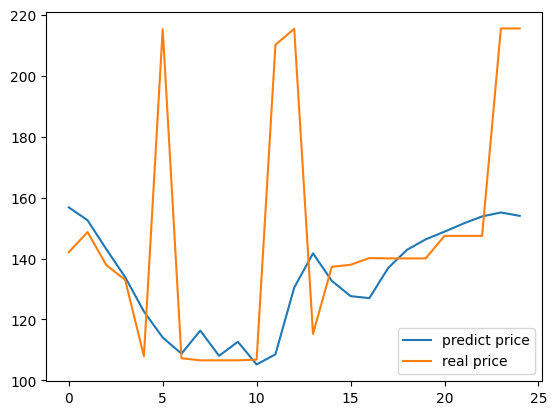

In [22]:
test(280)